## Vision Language Model

These are mutlimodal LLMs which can read both text and images as input and learns a joint representation between them.
Ususally used for captioning or generating images from texts etc.  

Has 3 main components:  
-> visual encoder: converts images to embeddings  
-> text encoder: converts text to its embedding  
-> Multimodal fusion module: where we find the joint representation of text and input embeddings



In [230]:
import math, random
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt


In [231]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
IMG_SZE = 32
EMBEDD_DIM = 64
ATTENTION_HEADS = 4
BATCH_SIZE = 12
EPOCHS = 20
LR = 3e-4
TEMP = 0.07       #lower temprature penalizes negative pairs more
MAX_LEN = 4

cpu


### Synthetic data generation

In [232]:
colors = ['red','green','blue','yellow','purple','orange','pink','brown','gray']
shapes = ['square','circle','triangle']
positions = ['left','right','corner','top','bottom','top-left','bottom-left','bottom-right','center']

In [233]:
#drawing image shapes
def draw_sample(color, shape, position, img_size=IMG_SZE):
  img  = Image.new('RGB', (img_size, img_size), 'white')
  draw = ImageDraw.Draw(img)
  margin = 6
  w = h = (img_size - 2*margin)

  #calculate coordinates
  if 'left' in positions:
    x0 = margin
    x1 = margin + w // 2
  elif 'right' in position:
    x0 = margin - w // 2
    x1 = img_size - margin
  elif 'bottom-left' in position:
    x0 = margin
    x1 = margin + w // 2
  elif 'top-right' in position:
    x0 = margin - w // 2
    x1 = img_size - margin
  elif 'top-left' in position:
    x0 = margin
    x1 = margin +  w // 2
  elif 'bottom-right' in position:
    x0 = margin + w // 2
    x1 = img_size - margin
  else:
    x0 = margin + w // 4
    x1 = margin + 3 * w // 4

  #calculate for y coordinate
  if 'top' in positions:
    y0 = margin
    y1 = margin + h // 2
  elif 'bottom' in position:
    y0 = margin + h // 2
    y1 = img_size - margin
  elif 'bottom-left' in position:
    y0 = margin + h // 2
    y1 = img_size - margin
  elif 'bottom-right' in position:
    y0 = margin + h // 2
    y1 = img_size - margin
  elif 'top-right' in position:
    y0 = margin
    y1 = margin +  h // 2
  elif 'top-left' in position:
    y0 = margin
    y1 = margin +  h // 2
  else:
    y0 = margin + h // 4
    y1 = margin + 3 * h // 4


  if shape=='square':
    draw.rectangle((x0, y0, x1, y1), fill=color, outline='black')
  elif shape=='circle':
    draw.ellipse((x0, y0, x1, y1), fill=color, outline='black')
  else:
    draw.polygon([(x0+(x1-x0)//2, y0), (x0, y1), (x1, y1)], fill=color, outline='black')

  return img


In [234]:
#class for building the dataset
class ShapesDataset():
  def __init__(self):
    self.images = []
    self.captions = []

    #all combinations
    for color in colors:
      for shape in shapes:
        for position in positions:
          img = draw_sample(color, shape, position)

          self.images.append(torch.from_numpy(np.asarray(img)).permute(2,0,1).float()/255.0) #our image
          self.captions.append(f'{color} {shape} {position}') #our caption wrt to the images

    self.vocab, self.words2idx = self.build_vocab(self.captions)

  def build_vocab(self, texts):
    words = sorted({w for t in texts for w in t.split()}) #splitting every caption from out dataset and creating a set of sorted tokens (like english dict)
    vocab = ['[CLS]'] + words
    w2i = {w:i for i,w in enumerate(vocab)}#word to index
    return vocab, w2i

  def encode_text(self, text):
    toks = [self.words2idx['[CLS]']] + [self.words2idx[w] for w in text.split()]
    return torch.tensor(toks, dtype=torch.long)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    return self.images[idx], self.encode_text(self.captions[idx]), self.captions[idx]



In [235]:
#create full dataset
full_ds = ShapesDataset()
VOCAB_SIZE = len(full_ds.vocab)
print(VOCAB_SIZE) # shuld be equal to 22 since cls + all_unique words which is 9 + 9 +3

22


In [236]:
#train-val dataset creation
train_size = int(0.8 * len(full_ds))
val_size = len(full_ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(full_ds, [train_size, val_size])

In [237]:
#create dataloaders
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

### Image encoder
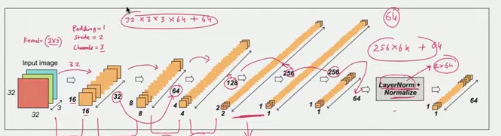  

4 conv operatio followed by GobalAveragePooling to convert the image to embedding


In [238]:
class ImageEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.convolutions = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3, padding=1, stride=2), #out_channels = number of kernels
        nn.ReLU(),
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3, padding=1, stride=2),
        nn.ReLU()
    )

    self.projection = nn.Linear(256, EMBEDD_DIM) #creating unit vector
    self.layernormal = nn.LayerNorm(EMBEDD_DIM)   #so that max and min val becomes 0 and 1 respectively

  def forward(self, x):
    x = self.convolutions(x)
    x = x.mean(dim=[2,3]) #GAP gobal avg pooling
    x = self.projection(x)
    x = F.normalize(self.layernormal(x), dim=-1)
    return x


### Text encoder
similar to BERT  
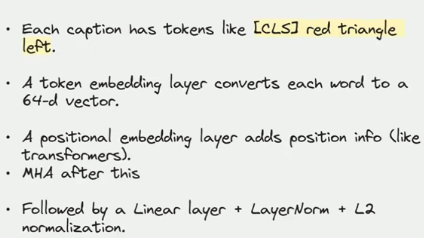

In [239]:
class TextEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.token_embedd = nn.Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=EMBEDD_DIM)
    self.position_embedd = nn.Embedding(num_embeddings=MAX_LEN, embedding_dim=EMBEDD_DIM)
    self.mha = nn.MultiheadAttention(embed_dim=EMBEDD_DIM, num_heads=ATTENTION_HEADS, batch_first=True)  #always include batch_first
    self.norm = nn.LayerNorm(EMBEDD_DIM)
    self.projection = nn.Linear(EMBEDD_DIM, EMBEDD_DIM)

  def forward(self, toks):
    N, L = toks.shape
    position_emb = torch.arange(L, device=toks.device).unsqueeze(0).expand(N,L)
    tok_emb = self.token_embedd(toks)
    pos_emb = self.position_embedd(position_emb)
    x = tok_emb + pos_emb
    x = self.mha(x, x, x)[0]   #Q, K, V
    x = x[:,0] #extraction cls embedding to use as final embedding
    x = self.projection(x)
    x = F.normalize(self.norm(x), dim=-1)

    return x

### CLIP Loss

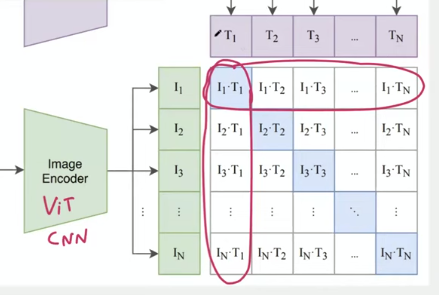  

The cosine compared to each text are found along column whereas cosine compared to each image are found along row

In [240]:
def clip_loss(img_embed, text_embed, temprature=TEMP):
  cosine = img_embed @ text_embed.T / temprature
  target = torch.arange(len(img_embed), device=img_embed.device)
  loss_i = F.cross_entropy(cosine, target)
  loss_t = F.cross_entropy(cosine.T, target)
  return (loss_i + loss_t)/2.0

### Model, data, optimizer

In [241]:
img_enc = ImageEncoder().to(device)
text_enc = TextEncoder().to(device)
params = list(img_enc.parameters()) + list(text_enc.parameters())
optimizer = torch.optim.AdamW(params, lr=LR)

Sample image and caption for embeddings visualizing: pink square bottom-left


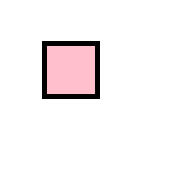

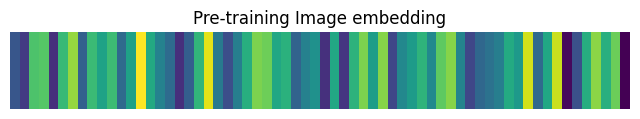

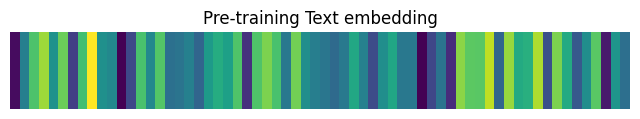

In [242]:
#visualizing embeddings
def show_image(t, title=None):
  img = (t.permute(1,2,0).numpy()*255).astype(np.uint8)
  plt.figure(figsize=(2.2,2.2))
  plt.axis("off")
  if title is not None:
    plt.title(title, fontsize=8)
  plt.imshow(img)

def plot_embedding(embedding, title):
  plt.figure(figsize=(8,1))
  plt.imshow(embedding.reshape(1, -1), aspect='auto', cmap='viridis')
  plt.title(title)
  plt.axis("off")
  plt.show()

img_enc.eval()
text_enc.eval()

with torch.no_grad():
  random_idx = random.randrange(len(full_ds))
  sample_img, sample_toks, sample_cap = full_ds[random_idx]
  sample_img = sample_img.unsqueeze(0).to(device)
  sample_toks = sample_toks.unsqueeze(0).to(device)
  pretrain_img_embed = img_enc(sample_img).squeeze(0).cpu().numpy()
  pretrain_text_embed = text_enc(sample_toks).squeeze(0).cpu().numpy()

  #image and caption
  print(f"Sample image and caption for embeddings visualizing: {sample_cap}")
  show_image(sample_img.squeeze(0)) #squeeze removes batch dimension

plot_embedding(pretrain_img_embed, "Pre-training Image embedding")
plot_embedding(pretrain_text_embed, "Pre-training Text embedding")

### Training Loop

In [243]:
best_val = float('inf')

for epoch in range(1, EPOCHS+1):
  img_enc.train()
  text_enc.train()
  total = 0.0

  #train
  for imgs, toks, _ in train_dl:
    imgs = imgs.to(device)
    toks = toks.to(device)

    optimizer.zero_grad(set_to_none=True)
    img_embed = img_enc(imgs)
    text_embed = text_enc(toks)
    loss = clip_loss(img_embed, text_embed)
    loss.backward()
    optimizer.step()
    total += loss.item()*imgs.size(0)
  train_loss = total / (len(train_dl)+BATCH_SIZE)

  #validation
  img_enc.eval()
  text_enc.eval()
  with torch.no_grad():
    vtotal, n = 0.0, 0
    for imgs, toks, _ in val_dl:
      imgs = imgs.to(device)
      toks = toks.to(device)
      vtotal += clip_loss(img_enc(imgs), text_enc(toks)).item()*imgs.size(0)
      n += imgs.size(0)
    val_loss = vtotal / n

  print(f"Epoch: {epoch}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}")
  best_val = min(best_val, val_loss)

Epoch: 1, Train Loss: 16.534, Val Loss: 2.177
Epoch: 2, Train Loss: 11.410, Val Loss: 1.409
Epoch: 3, Train Loss: 9.042, Val Loss: 1.354
Epoch: 4, Train Loss: 7.941, Val Loss: 0.890
Epoch: 5, Train Loss: 5.693, Val Loss: 1.005
Epoch: 6, Train Loss: 5.507, Val Loss: 0.513
Epoch: 7, Train Loss: 3.506, Val Loss: 0.464
Epoch: 8, Train Loss: 2.747, Val Loss: 0.364
Epoch: 9, Train Loss: 2.438, Val Loss: 0.313
Epoch: 10, Train Loss: 1.911, Val Loss: 0.303
Epoch: 11, Train Loss: 1.955, Val Loss: 0.295
Epoch: 12, Train Loss: 1.604, Val Loss: 0.291
Epoch: 13, Train Loss: 1.844, Val Loss: 0.284
Epoch: 14, Train Loss: 1.699, Val Loss: 0.281
Epoch: 15, Train Loss: 2.247, Val Loss: 0.279
Epoch: 16, Train Loss: 1.912, Val Loss: 0.278
Epoch: 17, Train Loss: 1.689, Val Loss: 0.277
Epoch: 18, Train Loss: 1.352, Val Loss: 0.276
Epoch: 19, Train Loss: 1.715, Val Loss: 0.275
Epoch: 20, Train Loss: 1.745, Val Loss: 0.276


Sample image and caption for embeddings visualizing: pink square bottom-left


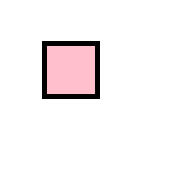

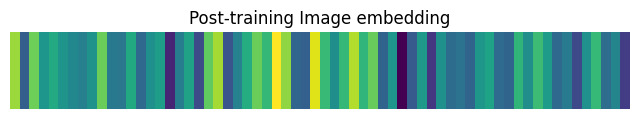

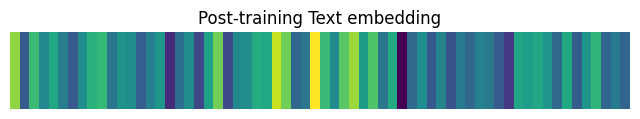

In [244]:
img_enc.eval()
text_enc.eval()
with torch.no_grad():
  sample_img, sample_toks, sample_cap = full_ds[random_idx]
  sample_img = sample_img.unsqueeze(0).to(device)
  sample_toks = sample_toks.unsqueeze(0).to(device)
  posttrain_img_embed = img_enc(sample_img).squeeze(0).cpu().numpy()
  posttrain_text_embed = text_enc(sample_toks).squeeze(0).cpu().numpy()

  #image and caption
  print(f"Sample image and caption for embeddings visualizing: {sample_cap}")
  show_image(sample_img.squeeze(0)) #squeeze removes batch dimension

plot_embedding(posttrain_img_embed, "Post-training Image embedding")
plot_embedding(posttrain_text_embed, "Post-training Text embedding")

Observation: Embeddings between text and image have started to look similar after training

### Inferencing

In [247]:
#building text bank on val set
img_enc.eval()
text_enc.eval()
with torch.no_grad():
  val_imgs, val_toks, val_caps = [], [], []
  for imgs, toks, caps in val_dl:
    val_imgs.append(imgs)
    val_toks.append(toks)
    val_caps.extend(caps)
  val_imgs = torch.cat(val_imgs)
  val_toks = torch.cat(val_toks)
  img_embed = img_enc(val_imgs)
  text_embed = text_enc(val_toks)

def text_to_img(k=3, idxs=None):
  if idxs is None:
    idxs = np.random.choice(len(val_caps), size=1, replace=False)
    sims = (img_embed @ text_embed.t().softmax(dim=1))
    for i in idxs:
      best = sims[i].topk(k).indices.tolist()
      print(f"\nImages {i} best captions:")
      for j in best:
        print(" -", val_caps[j])
      show_image(val_imgs[i])

def img_to_text(k=3, idxs=None):
  if idxs is None:
    idxs = np.random.choice(len(val_caps), size=1, replace=False)
    sims = (text_embed @ img_embed.t().softmax(dim=1))
    for i in idxs:
      best = sims[i].topk(k).indices.tolist()
      print(f"\nCaptions {i} best images:")
      for j in best:
        show_image(val_imgs[j].cpu(), title=f"match {val_caps[j]}")


Images 11 best captions:
 - gray square corner

Captions 9 best images:


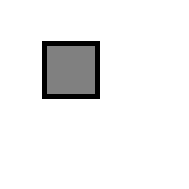

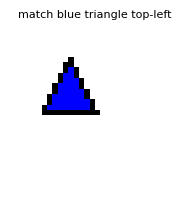

In [248]:
text_to_img(k=1)
img_to_text(k=1)